# Übung Simulation von Energiesystemen 
## PyPSA 05

Sie sollen die Wärmeversorgung für ein Einfamilienhaus auslegen. Ihr Auftraggeber möchte eine PV-Anlage installieren. Die Dachfläche bietet Platz für maximal 10 kWp. Neben der Selbstversorgung werden Sie mit 8 ct je eingespeiste kWh PV-Strom vergütet. Hierzu soll ebenfalls ein Batteriespeicher mit einer Kapazität von 10 kWh installiert werden.
Im Zuge der Installation der PV-Anlage will Ihr Auftraggeber ebenfalls eine Wärmepumpe installieren. Als Informationen haben Sie einen simulierten Heizlastgang des Gebäudes, sowie den Stromverbrauch zur Verfügung gestellt bekommen. Ebenfalls soll ein 300 l Warmwasserspeicher installiert werden.


Importieren Sie die notwendigen Bibliotheken

In [1]:
import numpy as np
import pandas as pd
import pypsa

Lesen Sie die Daten ein

<Axes: >

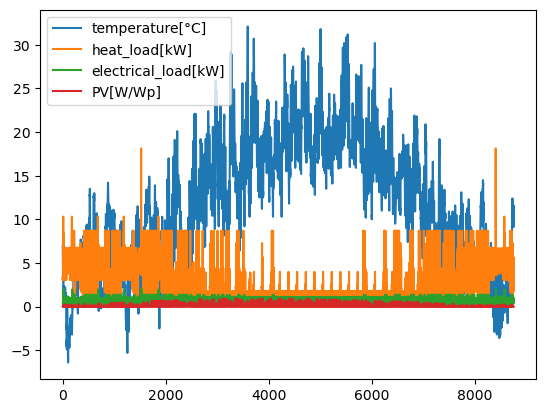

In [2]:
df_data = pd.read_excel("data_PyPSA05.xlsx")
df_data.plot()

Im Folgenden wird anhand des Datenblatts der Wärmepumpe die Leistungszahl (COP) und die elektrische Leistungsaufnahme in Abhängikeit der Außentemperatur interpoliert. Die Daten für die Wärmepumpe basieren auf der Viessmann VITOCAL 252-A (Typ AWOT-E-AC-AF 251.A13) mit einer elektrischen Nennleistung nach DIN 14511 (A7/W35) von 1,56 kW. <br>
Quelle: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjh5q_1hPGKAxXV_rsIHfQcKdIQFnoECBkQAQ&url=https%3A%2F%2Fcommunity.viessmann.de%2Fviessmann%2Fattachments%2Fviessmann%2Fcustomers-heatpump-hybrid%2F109104%2F1%2Fpa-viessmann-Vitocal-250-A-252-A-Monoblock-2%2C6-bis-13%2C4kW-2%2520(1).pdf&usg=AOvVaw3pqAJU6jhNcSjoQFrXXLVN&opi=89978449

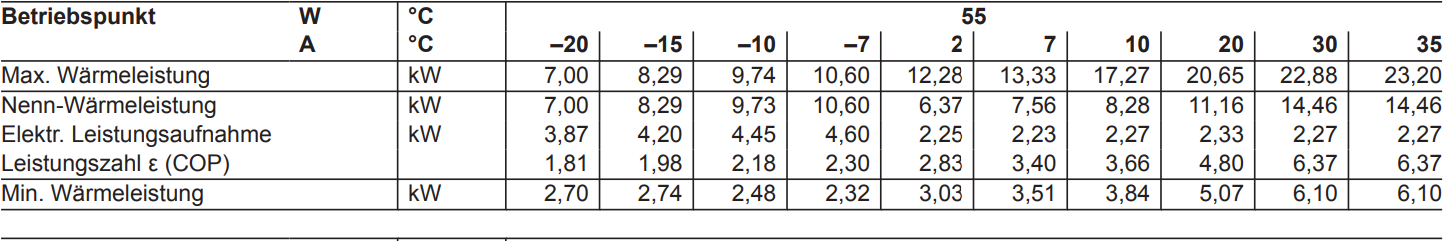

In [3]:
temp        =   [ -20, -15, -10,  -7,   2,   7,  10,  20,  30,  35] #°C
el_power    =   [3.87,4.20,4.45,4.60,2.25,2.23,2.27,2.33,2.27,2.27] #kW
cop         =   [1.81,1.98,2.18,2.30,2.83,3.40,3.66,4.80,6.37,6.37]
hp_p_nom    =   1.56 #kW

In [6]:
df_data

,temperature[°C],heat_load[kW],electrical_load[kW],PV[W/Wp],COP_heat_pump,el_p_pu
0,7.1,3.278302,0.382568,0.0,3.408667,1.430342
1,5.3,3.079617,0.334995,0.0,3.206200,1.433846
2,4.0,3.476987,0.282466,0.0,3.058000,1.437179
3,3.8,3.576330,0.282466,0.0,3.035200,1.437692
4,3.5,2.980275,0.271564,0.0,3.001000,1.438462
...,...,...,...,...,...,...
8755,10.5,1.748073,0.615775,0.0,3.717000,1.457051
8756,11.1,1.850900,0.677061,0.0,3.785400,1.459359
8757,11.6,5.679317,0.889129,0.0,3.842400,1.461282
8758,10.7,2.056556,0.777258,0.0,3.739800,1.457821


In [5]:
df_data["COP_heat_pump"] = np.interp(df_data['temperature[°C]'],temp,cop)
df_data["el_p_pu"]       = (np.interp(df_data['temperature[°C]'],temp,el_power))/hp_p_nom

<Axes: xlabel='temperature[°C]'>

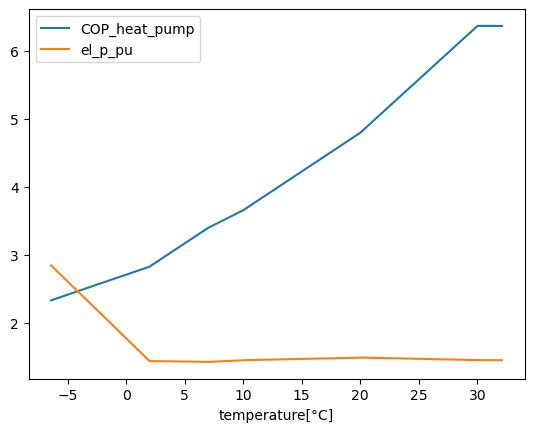

In [7]:
df_data.loc[:,["temperature[°C]","COP_heat_pump","el_p_pu"]].sort_values(['temperature[°C]']).plot(x='temperature[°C]')

### Netzwerkskizze

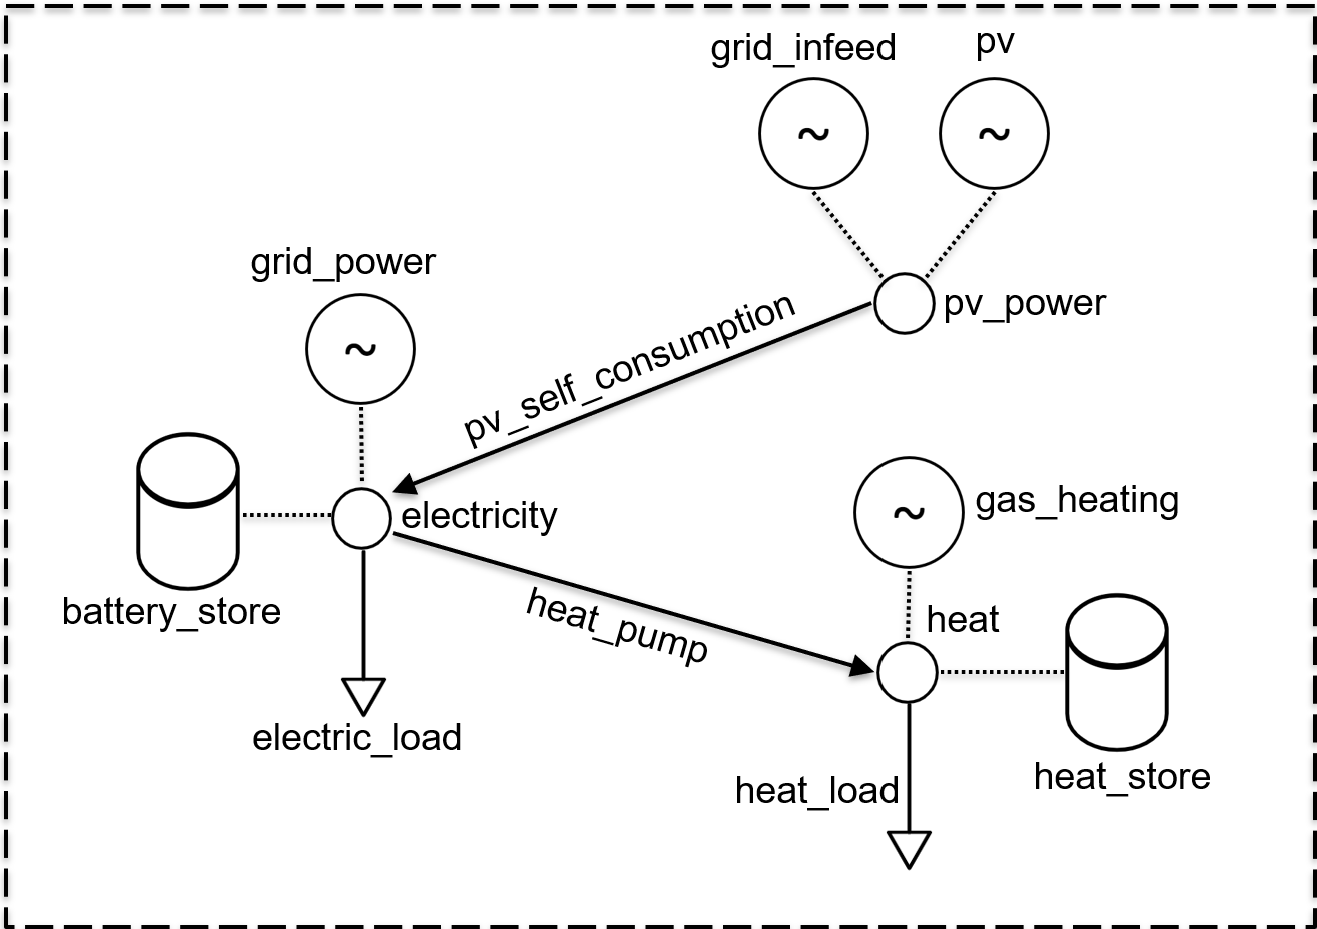

Implementieren Sie das Netzwerk. 
Nutzen Sie dabei die folgenden zusätzlichen Angaben.

In [8]:
# Assumptions   
pv_p_nom_max            = 10    # kWp
battery_e_nom           = 10    # kWh
heat_store_e_nom        = 8.7   # kWh (entspricht einem 300 l Pufferspeicher bei einer Temperaturspreizung von 25 K)

#lifespan wird für die Berechnung der Kosten angegeben
lifespan_pv             = 20    # Jahre
lifespan_hp             = 20    # Jahre
lifespan_battery        = 15    # Jahre
lifespan_heat_store     = 25    # Jahre

invest_pv_annuity       = 65    # €/(kW*a)
invest_hp_annuity       = 480   # €/(kW*a)
invest_battery_annuity  = 25    # €/(kWh*a)
invest_heat_store_annuity= 5    # €/(kWh*a)

electrical_rate         = 0.34  # €/kWh
feed_in_tariff          =-0.08  # €/kWh

heat_storage_loss       = 0.005

In [19]:
# Netzwerk aufbauen
network = pypsa.Network()
network.set_snapshots(range(8760))

#Bus
network.add('Bus', name = 'pv_power')
network.add('Bus', name = 'electricity')
network.add('Bus', name = 'heat')

#Load
network.add('Load',
            name  = 'electric_load', 
            bus   = 'electricity', 
            p_set = df_data["electrical_load[kW]"])
network.add('Load', 
            name  = 'heat_load', 
            bus   = 'heat', 
            p_set = df_data["heat_load[kW]"])

#Generator
network.add('Generator',
            name  = 'grid_power',
            bus   = 'electricity', 
            p_nom = np.inf, 
            marginal_cost   = electrical_rate)
network.add('Generator',
            name  = 'PV', 
            bus   = 'pv_power', 
            p_nom_extendable= True,
            p_nom_max       = pv_p_nom_max, 
            p_max_pu        = df_data["PV[W/Wp]"],
            capital_cost    = invest_pv_annuity,
            lifetime = lifespan_pv) #lifetime wird für die Berechnung der Kosten angegeben
network.add('Generator',
            name  = 'grid_infeed', 
            bus   = 'pv_power', 
            p_nom =  np.inf, 
            marginal_cost   = feed_in_tariff,
            sign  = -1)

#Link
network.add('Link',
            name  = 'pv_self_consumption',
            bus0  = 'pv_power', 
            bus1  = 'electricity',
            p_nom = np.inf)

#################### - implement Heatpump here - ####################

network.add('Link', 
            name = 'heat_pump',
            bus0 = 'electricity',
            bus1 = 'heat',
            efficiency = df_data["COP_heat_pump"],
            p_max_pu = df_data["el_p_pu"],
            p_nom_extendable = True,
            capital_cost = invest_hp_annuity,
            lifetime = lifespan_hp) #lifetime wird für die Berechnung der Kosten angegeben


#####################################################################

#Store
network.add('Store',
            name             = 'battery_store',
            bus              = 'electricity',
            e_nom            = battery_e_nom,
            capital_cost     = invest_battery_annuity,
            e_cyclic         = True,
            lifetime         = lifespan_battery ) #lifetime wird für die Berechnung der Kosten angegeben
network.add('Store',
            name             = 'heat_store',
            bus              = 'heat',
            e_nom            = heat_store_e_nom,
            capital_cost     = invest_heat_store_annuity,
            standing_loss    = heat_storage_loss,
            e_cyclic         = True,
            lifetime         = lifespan_heat_store) #lifetime wird für die Berechnung der Kosten angegeben

Optimieren Sie das Netzwerk

In [20]:
network.optimize(solver_name='gurobi', methods = 1, threads = 1)

Index(['pv_power', 'electricity', 'heat'], dtype='object', name='Bus')
Index(['pv_self_consumption', 'heat_pump'], dtype='object', name='Link')
Index(['battery_store', 'heat_store'], dtype='object', name='Store')
Index(['pv_power', 'electricity', 'heat'], dtype='object', name='Bus')
Index(['pv_self_consumption', 'heat_pump'], dtype='object', name='Link')
Index(['battery_store', 'heat_store'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - methods: 1
 - threads: 1


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 38.88it/s]
INFO:linopy.io: Writing time: 0.89s


Read LP format model from file /tmp/linopy-problem-73bvg9x3.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-73bvg9x3.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 166443 rows, 78842 columns, 267319 nonzeros


INFO:gurobipy:obj: 166443 rows, 78842 columns, 267319 nonzeros


No parameters matching 'methods' found


INFO:gurobipy:No parameters matching 'methods' found


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


INFO:gurobipy:Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Optimize a model with 166443 rows, 78842 columns and 267319 nonzeros


INFO:gurobipy:Optimize a model with 166443 rows, 78842 columns and 267319 nonzeros


Model fingerprint: 0xc86eaa16


INFO:gurobipy:Model fingerprint: 0xc86eaa16


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-02, 6e+00]


INFO:gurobipy:  Matrix range     [1e-02, 6e+00]


  Objective range  [8e-02, 5e+02]


INFO:gurobipy:  Objective range  [8e-02, 5e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-01, 1e+100]


INFO:gurobipy:  RHS range        [1e-01, 1e+100]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 146636 rows and 39405 columns


INFO:gurobipy:Presolve removed 146636 rows and 39405 columns


Presolve time: 0.19s


INFO:gurobipy:Presolve time: 0.19s


Presolved: 19807 rows, 39437 columns, 70530 nonzeros


INFO:gurobipy:Presolved: 19807 rows, 39437 columns, 70530 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.6758944e+02   3.887258e+04   0.000000e+00      0s


INFO:gurobipy:       0    8.6758944e+02   3.887258e+04   0.000000e+00      0s


   14400    2.7941204e+03   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   14400    2.7941204e+03   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 14400 iterations and 0.57 seconds (0.38 work units)


INFO:gurobipy:Solved in 14400 iterations and 0.57 seconds (0.38 work units)


Optimal objective  2.794120370e+03


INFO:gurobipy:Optimal objective  2.794120370e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78842 primals, 166443 duals
Objective: 2.79e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

Lassen Sie sich die optimale Leistung der Wärmepumpe und der PV-Anlage ausgeben

In [21]:
network.links.p_nom_opt['heat_pump']

2.300712040748224

In [22]:
network.generators.p_nom_opt['PV']

10.0

Berechnen Sie die Investitions- und Betriebskosten

In [23]:
invest_cost_stores      = network.stores.e_nom_opt * network.stores.capital_cost * network.stores.lifetime
invest_cost_generators  = network.generators.p_nom_opt * network.generators.capital_cost * network.generators.lifetime
invest_cost_links       = network.links.p_nom_opt * network.links.capital_cost * network.links.lifetime
df_invest_cost          = pd.concat([invest_cost_stores,invest_cost_generators,invest_cost_links])
invest_cost             = round(df_invest_cost.sum(),2)

operational_cost        = round((network.generators_t.p.sum() * network.generators.marginal_cost).sum(),2)

print("Installierte Wärmepumpenleistung:", round(network.links.p_nom_opt.heat_pump,2), "kW")
print("Installierte PV-Anlage:", network.generators.p_nom_opt.PV, "kWp")
print("Installierte Batteriespeicherkapazität:", round(network.stores.e_nom_opt.battery_store,2), "kWh")
print("Installierte Pufferspeicherkapazität:", round(network.stores.e_nom_opt.heat_store,2), "kWh")
print("Die Investitionskosten belaufen sich auf:",invest_cost,"€")
print("Die Betriebskosten belaufen sich auf:",operational_cost,"€/a")
df_invest_cost

Installierte Wärmepumpenleistung: 2.3 kW
Installierte PV-Anlage: 10.0 kWp
Installierte Batteriespeicherkapazität: 10.0 kWh
Installierte Pufferspeicherkapazität: 8.7 kWh
Die Investitionskosten belaufen sich auf: 39924.34 €
Die Betriebskosten belaufen sich auf: 1039.78 €/a


battery_store           3750.000000
heat_store              1087.500000
grid_power                      NaN
PV                     13000.000000
grid_infeed                     NaN
pv_self_consumption             NaN
heat_pump              22086.835591
dtype: float64

Lassen Sie nun die Speicherkapazitäten bei der Optimierung auslegen

In [27]:
network.stores.loc['battery_store', 'e_nom_extendable'] = True
network.stores.loc['heat_store', 'e_nom_extendable'] = True

Optimieren Sie das Netzwerk

In [29]:
network.optimize(solver_name='gurobi', method = 1, threads = 1)

Index(['pv_power', 'electricity', 'heat'], dtype='object', name='Bus')
Index(['pv_self_consumption', 'heat_pump'], dtype='object', name='Link')
Index(['battery_store', 'heat_store'], dtype='object', name='Store')
Index(['pv_power', 'electricity', 'heat'], dtype='object', name='Bus')
Index(['pv_self_consumption', 'heat_pump'], dtype='object', name='Link')
Index(['battery_store', 'heat_store'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 1
 - threads: 1


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 51.94it/s]
INFO:linopy.io: Writing time: 0.91s


Read LP format model from file /tmp/linopy-problem-g_s7aca1.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-g_s7aca1.lp


Reading time = 0.30 seconds


INFO:gurobipy:Reading time = 0.30 seconds


obj: 166445 rows, 78845 columns, 284841 nonzeros


INFO:gurobipy:obj: 166445 rows, 78845 columns, 284841 nonzeros


Set parameter Method to value 1


INFO:gurobipy:Set parameter Method to value 1


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


INFO:gurobipy:Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Optimize a model with 166445 rows, 78845 columns and 284841 nonzeros


INFO:gurobipy:Optimize a model with 166445 rows, 78845 columns and 284841 nonzeros


Model fingerprint: 0x6605e57f


INFO:gurobipy:Model fingerprint: 0x6605e57f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-02, 6e+00]


INFO:gurobipy:  Matrix range     [1e-02, 6e+00]


  Objective range  [8e-02, 5e+02]


INFO:gurobipy:  Objective range  [8e-02, 5e+02]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-01, 1e+100]


INFO:gurobipy:  RHS range        [1e-01, 1e+100]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 124680 rows and 41321 columns


INFO:gurobipy:Presolve removed 124680 rows and 41321 columns


Presolve time: 0.42s


INFO:gurobipy:Presolve time: 0.42s


Presolved: 41765 rows, 37524 columns, 117989 nonzeros


INFO:gurobipy:Presolved: 41765 rows, 37524 columns, 117989 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0   -5.2866800e+02   1.513902e+04   0.000000e+00      0s


INFO:gurobipy:       0   -5.2866800e+02   1.513902e+04   0.000000e+00      0s


   31274    2.2099677e+03   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   31274    2.2099677e+03   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 31274 iterations and 3.70 seconds (3.74 work units)


INFO:gurobipy:Solved in 31274 iterations and 3.70 seconds (3.74 work units)


Optimal objective  2.209967716e+03


INFO:gurobipy:Optimal objective  2.209967716e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78845 primals, 166445 duals
Objective: 2.21e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

Geben Sie sich erneut die optimale Wärmepumpenleistung aus. Zudem lassen Sie sich die optimale Kapazitäten der Speicher ausgeben

In [30]:
network.links.p_nom_opt['heat_pump']

1.105724984326153

In [31]:
network.stores.e_nom_opt

Store
battery_store     4.929324
heat_store       22.679291
Name: e_nom_opt, dtype: float64

Berechnen Sie erneut die Investitions- und Betriebskosten

In [32]:
invest_cost_stores      = network.stores.e_nom_opt * network.stores.capital_cost * network.stores.lifetime
invest_cost_generators  = network.generators.p_nom_opt * network.generators.capital_cost * network.generators.lifetime
invest_cost_links       = network.links.p_nom_opt * network.links.capital_cost * network.links.lifetime
df_invest_cost          = pd.concat([invest_cost_stores,invest_cost_generators,invest_cost_links])
invest_cost             = round(df_invest_cost.sum(),2)

operational_cost        = round((network.generators_t.p.sum() * network.generators.marginal_cost).sum(),2)

print("Installierte Wärmepumpenleistung:", round(network.links.p_nom_opt.heat_pump,2), "kW")
print("Installierte PV-Anlage:", network.generators.p_nom_opt.PV, "kWp")
print("Installierte Batteriespeicherkapazität:", round(network.stores.e_nom_opt.battery_store,2), "kWh")
print("Installierte Pufferspeicherkapazität:", round(network.stores.e_nom_opt.heat_store,2), "kWh")
print("Die Investitionskosten belaufen sich auf:",invest_cost,"€")
print("Die Betriebskosten belaufen sich auf:",operational_cost,"€/a")
df_invest_cost

Installierte Wärmepumpenleistung: 1.11 kW
Installierte PV-Anlage: 10.0 kWp
Installierte Batteriespeicherkapazität: 4.93 kWh
Installierte Pufferspeicherkapazität: 22.68 kWh
Die Investitionskosten belaufen sich auf: 28298.37 €
Die Betriebskosten belaufen sich auf: 1086.09 €/a


battery_store           1848.496382
heat_store              2834.911330
grid_power                      NaN
PV                     13000.000000
grid_infeed                     NaN
pv_self_consumption             NaN
heat_pump              10614.959850
dtype: float64